***
## Table of Contents
<br>
    <ol><h2><a href='#0' style="text-decoration : none; color : #000000;">1. Loading and Cleaning Data </a></h2> </ol>
    <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">2. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">3. Feature Transformation with feature selection </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">4. Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">5.Over Sampling</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">6.Under Sampling</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#5.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#6' style="text-decoration : none; color : #000000;">5. Comparing Results</a></h2>  
     </ol>
     <br>

In [1]:
import pandas as pd
import numpy as np
import os
import json
from pandas.io.json import json_normalize
from IPython.display import display,clear_output,HTML
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from tabulate import tabulate

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression,RandomizedLasso,LinearRegression, Ridge,Lasso
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split,cross_val_score

from sklearn.preprocessing import MinMaxScaler,StandardScaler,binarize
from sklearn.ensemble import RandomForestRegressor
# from minepy import MINE
from sklearn import metrics

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score
from sklearn import metrics
from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats

Using TensorFlow backend.


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
#     m['Features']=m['Features'].str.replace("dom_function_","")
#     m['Features']=m['Features'].str.replace("js_function_","")
#     m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
#     m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

In [3]:
def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)
    
    y_pred_train=knn.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the KNN model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=knn.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the KNN model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return knn,cm_train,cm_test,acc_train,acc_test,roc_auc

In [4]:
def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression()
    log.fit(X_train,Y_train)
    
    y_pred_train=log.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Logistic Regression model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=log.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Logistic Regression model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return log,cm_train,cm_test,acc_train,acc_test,roc_auc

In [5]:
def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)
    
    y_pred_train=rf.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Random Forest Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=rf.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Random Forest Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(rf.feature_importances_,feat)
    return rf,cm_train,cm_test,acc_train,acc_test,roc_auc,rf.feature_importances_

In [6]:
def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    ada.fit(X_train,Y_train)
    
    y_pred_train=ada.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Ada Boost Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=ada.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Ada Boost Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(ada.feature_importances_,feat)
    return ada,cm_train,cm_test,acc_train,acc_test,roc_auc,ada.feature_importances_

In [7]:
def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    gbc.fit(X_train,Y_train)
    
    y_pred_train=gbc.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Gradient Boosting Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=gbc.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Gradient Boosting Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(gbc.feature_importances_,feat)
    return gbc,cm_train,cm_test,acc_train,acc_test,roc_auc,gbc.feature_importances_

In [8]:
def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier()
    ext_tree.fit(X_train,Y_train)
    
    y_pred_train=ext_tree.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Extra Tree Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=ext_tree.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Extra Tree Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(ext_tree.feature_importances_,feat)
    return ext_tree,cm_train,cm_test,acc_train,acc_test,roc_auc,ext_tree.feature_importances_

In [9]:
def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    bagging.fit(X_train,Y_train)
    
    y_pred_train=bagging.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Bagging model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=bagging.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Bagging model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return bagging,cm_train,cm_test,acc_train,acc_test,roc_auc

In [10]:
def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc

### <a id='0' style="text-decoration : none; color : #000000;"> 1. Loading and Cleaning Data</a>

In [38]:
df=pd.read_csv('Modified_http.csv')

# df.drop(['Unnamed: 0'],axis=1,inplace=True)


df.rename(columns={'Malicious':'Target'},inplace=True)

df.fillna(value=0,inplace=True)

cookies=[columns for columns in df.columns if 'number' in columns]

df.drop(cookies,axis=1,inplace=True)
df=df[df['domain']!=0]
df.sort_values(by='Target',inplace=True,ascending=False)

df.drop_duplicates(['domain'], keep='first',inplace=True)

df=df.sample(frac=1,random_state=0)
df.set_index(['domain'],drop=True,inplace=True)
display(df.head())
print("Shape of our dataset:",df.shape)

,Target,http_header-access-control-origin_http:,http_header-access-control-origin_https:,http_header_access-control-allow-credentials,http_header_access-control-allow-methods_cancelupload,http_header_access-control-allow-methods_checkin,http_header_access-control-allow-methods_connect,http_header_access-control-allow-methods_debug,http_header_access-control-allow-methods_delete,http_header_access-control-allow-methods_get,http_header_access-control-allow-methods_head,http_header_access-control-allow-methods_link,http_header_access-control-allow-methods_mkcol,http_header_access-control-allow-methods_move,http_header_access-control-allow-methods_options,http_header_access-control-allow-methods_patch,http_header_access-control-allow-methods_post,http_header_access-control-allow-methods_propfind,http_header_access-control-allow-methods_prpatch,http_header_access-control-allow-methods_put,http_header_access-control-allow-methods_report,http_header_access-control-allow-methods_should,http_header_access-control-allow-methods_trace,http_header_access-control-allow-methods_unlink,http_header_access-control-allow-methods_update,http_header_access-control-custom_count,http_header_access-control-expose-headers_set_true,http_header_access-control-expose-total_count,http_header_access-control-max-age,http_header_cache-control_set_max-age,http_header_cache-control_set_must-revalidate,http_header_cache-control_set_no-cache,http_header_cache-control_set_no-store,http_header_cache-control_set_no-transform,http_header_cache-control_set_private,http_header_cache-control_set_proxy-revalidate,http_header_cache-control_set_public,http_header_cache-control_set_s-maxage,http_header_connection_close,http_header_connection_keep-alive,http_header_content-disposition_attachment,http_header_content-disposition_inline,http_header_content-encoding_br,http_header_content-encoding_compress,http_header_content-encoding_deflate,http_header_content-encoding_gzip,http_header_content-encoding_identify,http_header_content-language_aa,http_header_content-language_ae,http_header_content-language_af,http_header_content-language_ak,http_header_content-language_am,http_header_content-language_an,http_header_content-language_application/*,http_header_content-language_application/ecmascript,http_header_content-language_application/json,http_header_content-language_application/octet-stream,http_header_content-language_ar,http_header_content-language_as,http_header_content-language_audio/*,http_header_content-language_audio/mpeg,http_header_content-language_audio/ogg,http_header_content-language_av,http_header_content-language_ay,http_header_content-language_az,http_header_content-language_ba,http_header_content-language_be,http_header_content-language_bg,http_header_content-language_bh,http_header_content-language_bi,http_header_content-language_blocked-uri,http_header_content-language_bm,http_header_content-language_bn,http_header_content-language_bo,http_header_content-language_br,http_header_content-language_bs,http_header_content-language_ca,http_header_content-language_ce,http_header_content-language_ch,http_header_content-language_co,http_header_content-language_cr,http_header_content-language_cs,http_header_content-language_cu,http_header_content-language_cv,http_header_content-language_cy,http_header_content-language_da,http_header_content-language_de,http_header_content-language_disposition,http_header_content-language_document-uri,http_header_content-language_dv,http_header_content-language_dz,http_header_content-language_ee,http_header_content-language_effective-directive,http_header_content-language_el,http_header_content-language_en,http_header_content-language_eo,http_header_content-language_es,http_header_content-language_et,http_header_content-language_eu,http_header_content-language_fa,http_header_content-language_ff,http_header_content-language_fi,http_header_content-language_fj,http_header_content-language_fo,http_header_content-language_fr,http_header_co

Shape of our dataset: (45856, 672)


#### Let us analyze the balance of classes

In [39]:
data = [go.Bar(x=df.Target.value_counts().index.values,
               y=df.Target.value_counts().values,
               text=df.Target.value_counts().values,
               textposition = 'outside',
            )]
layout = go.Layout( xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
fig = go.Figure(data=data, layout=layout)
iplot(fig)

#### We can see from the graph that there is high imbalance in the dataset. We can handle it either by oversampling, undersampling or tuning our models to focus on recall/precision to address the problem

#### Cleaning and analyzing the dataset.


#### We know that many of the features will all have no more than one unique value. Hence, we will first identify and drop those features

#### Columns which have do not have any unique values

In [40]:
col_no_unique=[]
for col in df.columns[:-1]:
    if len(df[col].value_counts())==1:
        print(col)
        col_no_unique.append(col)

print("{} columns have only one unique value in them rendering them meaningless for classification".format(len(col_no_unique)))

### Drop those columns
df.drop(col_no_unique,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df.shape)

http_header_access-control-allow-methods_prpatch
http_header_access-control-expose-headers_set_true
http_header_content-encoding_br
http_header_content-encoding_compress
http_header_content-encoding_identify
http_header_content-language_aa
http_header_content-language_ak
http_header_content-language_application/*
http_header_content-language_application/ecmascript
http_header_content-language_as
http_header_content-language_audio/*
http_header_content-language_audio/mpeg
http_header_content-language_audio/ogg
http_header_content-language_av
http_header_content-language_ay
http_header_content-language_ba
http_header_content-language_bg
http_header_content-language_bh
http_header_content-language_blocked-uri
http_header_content-language_bm
http_header_content-language_bn
http_header_content-language_bo
http_header_content-language_ce
http_header_content-language_cr
http_header_content-language_cv
http_header_content-language_document-uri
http_header_content-language_dv
http_header_conten

http_header_vary_sourcemap
http_header_vary_strict-transport-security
http_header_vary_timing-allow-origin
http_header_vary_tk
http_header_vary_trailer
http_header_vary_transfer-encoding
http_header_vary_via
http_header_vary_warning
http_header_vary_www-authenticate
http_header_vary_x-content-type-options
http_header_vary_x-dns-prefetch-control
http_header_vary_x-forwareded-for
http_header_vary_x-froward-host
http_header_vary_x-xss-protection
http_header_via_0.9
http_header_warn-code_accept
http_header_warn-code_accept-charset
http_header_warn-code_accept-encoding
http_header_warn-code_accept-language
http_header_warn-code_accept-ranges
http_header_warn-code_access-conotrol-request-headers
http_header_warn-code_access-control-allow-credentials
http_header_warn-code_access-control-allow-headers
http_header_warn-code_access-control-allow-methods
http_header_warn-code_access-control-allow-origin
http_header_warn-code_access-control-expose-headers
http_header_warn-code_access-control-max-a

In [41]:
# ### Check and converting data types
# df['Target']=df.Target.apply(lambda x: 1 if x=='Malicious' else 0)

print("Columns which are of type object:",df.dtypes[(df.dtypes=='object')])

Columns which are of type object: Series([], dtype: object)


#### Check for missing data

In [42]:
df.isnull().sum()

Target                                                           0
http_header-access-control-origin_http:                          0
http_header-access-control-origin_https:                         0
http_header_access-control-allow-credentials                     0
http_header_access-control-allow-methods_cancelupload            0
http_header_access-control-allow-methods_checkin                 0
http_header_access-control-allow-methods_connect                 0
http_header_access-control-allow-methods_debug                   0
http_header_access-control-allow-methods_delete                  0
http_header_access-control-allow-methods_get                     0
http_header_access-control-allow-methods_head                    0
http_header_access-control-allow-methods_link                    0
http_header_access-control-allow-methods_mkcol                   0
http_header_access-control-allow-methods_move                    0
http_header_access-control-allow-methods_options              

#### No missing data exists

#### Next check to see which features have less than 5% varying data

In [43]:
lst=[]
for col in df.columns[:-1]:
    lst.append([col,dict(df[col].value_counts()),df[col].value_counts().values[0]>=len(df)*0.95])

col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
col_values.set_index('Feature',drop=True,inplace=True)
del lst

print("{} columns have more than 95% same values".format(len(col_values[col_values['95_%_same_values']==True].index.values)))

245 columns have more than 95% same values


In [44]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [45]:
columns=col_values[col_values['95_%_same_values']==False].index.values

#### lets see if for the rest of continuous variables if there exists any relationship using Point biserial correlation.
####  The PointBiserial Correlation is a special case of Pearson co-rrelation for Correlation between continuous and dichotomus binary variable. 

In [46]:
df_sel=df[columns]

cat_var_js,num_var_js=check_cat(df_sel)

print("Stats for numerical features for HTML experiment\n")
num_stats_js=num_stats(df_sel,num_var_js)
display(num_stats_js)
print("\nStats for Categorical features for HTML experiment\n")
cat_stats_js=cat_stats(df_sel,cat_var_js)
display(cat_stats_js)

Stats for numerical features for HTML experiment



,Pt. Biserial Corr,Pt. Biserial Corr p-val,ttest,ttest p-val
Feature,,,,
http_header_marco_contenttext,-0.457291,0.000000e+00,-72.017274,0.000000e+00
http_header_x-cintent-type-options_nosniff,-0.140954,3.993026e-202,-64.192673,0.000000e+00
http_header_strict-transport-security_max-age,-0.137176,1.926210e-191,-61.878219,0.000000e+00
http_header_content-length,-0.072521,1.598452e-54,-19.896051,2.042365e-86



Stats for Categorical features for HTML experiment



,Pearson Chi-square,p-value,Cramers V
Feature,,,
http_header_content-encoding_gzip,9686.2477,0.0,0.4596
http_header_content-language_text/html,9548.2797,0.0,0.4563
http_header_vary_accept,5024.0796,0.0,0.3310
http_header_vary_accept-encoding,4979.9830,0.0,0.3295
http_header_connection_keep-alive,4052.6234,0.0,0.2973
http_header_transfer-encoding_chunked,3995.7784,0.0,0.2952
http_header_cache-control_set_max-age,1868.6053,0.0,0.2019
http_header_server_nginx,1404.5624,0.0,0.1750
http_header_x-xss-enabled,771.5071,0.0,0.1297


#### The ttest conduncted supports the results of point biserial correlation. 

#### Hence, we see that all the features we selected are related to the dependent variable.

### Lets start by building some basic models 

In [52]:
num_stats_js[0:50].index.values

['http_header_marco_contenttext',
 'http_header_x-cintent-type-options_nosniff',
 'http_header_strict-transport-security_max-age',
 'http_header_content-length']

In [59]:
print("Features we will be using:")
columns=num_stats_js[0:50].index.values.tolist() + cat_stats_js[0:50].index.values.tolist()
# columns=columns+['Target']
display(columns)

Features we will be using:


['http_header_marco_contenttext',
 'http_header_x-cintent-type-options_nosniff',
 'http_header_strict-transport-security_max-age',
 'http_header_content-length',
 'http_header_content-encoding_gzip',
 'http_header_content-language_text/html',
 'http_header_vary_accept',
 'http_header_vary_accept-encoding',
 'http_header_connection_keep-alive',
 'http_header_transfer-encoding_chunked',
 'http_header_cache-control_set_max-age',
 'http_header_server_nginx',
 'http_header_x-xss-enabled',
 'http_header_cache-control_set_private',
 'http_header_expect-ctmax-age',
 'http_header_expect-ctreport-uri',
 'http_header_cache-control_set_must-revalidate',
 'http_header_via_1.1',
 'http_header_cache-control_set_no-cache',
 'http_header_cache-control_set_public',
 'http_header_cache-control_set_no-store',
 'http_header_pragmano-cache',
 'http_header_server_apache',
 'http_header_connection_close',
 'http_header_vary_age',
 'http_header_vary_user-agent']

In [60]:
### Preparing our training and test sets
X=df[columns].values
y=df.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [61]:
f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

In [62]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [63]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.907752698724
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29085  2784    31869
True         600  4215     4815
__all__    29685  6999    36684

Accuracy of the KNN model for twst data is: 0.903074574793
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7234   732     7966
True         157  1049     1206
__all__     7391  1781     9172



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.883682259296
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29137  2732    31869
True        1535  3280     4815
__all__    30672  6012    36684

Accuracy of the Logistic Regression model for twst data is: 0.886066288705
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7298   668     7966
True         377   829     1206
__all__     7675  1497     9172



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.919092792498
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29383  2486    31869
True         482  4333     4815
__all__    29865  6819    36684

Accuracy of the Random Forest Classifier for twst data is: 0.909180113389
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7296   670     7966
True         163  1043     1206
__all__     7459  1713     9172



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.895022353069
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29326  2543    31869
True        1308  3507     4815
__all__    30634  6050    36684

Accuracy of the Ada Boost Classifier for twst data is: 0.896314871348
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7333   633     7966
True         318   888     1206
__all__     7651  1521     9172



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.904944935122
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29378  2491    31869
True         996  3819     4815
__all__    30374  6310    36684

Accuracy of the Gradient Boosting Classifier for twst data is: 0.906018316616
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7335   631     7966
True         231   975     1206
__all__     7566  1606     9172



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.920810162469
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29405  2464    31869
True         441  4374     4815
__all__    29846  6838    36684

Accuracy of the Extra Tree Classifier for twst data is: 0.908634976014
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7285   681     7966
True         157  1049     1206
__all__     7442  1730     9172



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.919283611384
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29390  2479    31869
True         482  4333     4815
__all__    29872  6812    36684

Accuracy of the Bagging model for twst data is: 0.909725250763
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7301   665     7966
True         163  1043     1206
__all__     7464  1708     9172



Neural Network-1
The accuracy of the model on training data is: 0.90682586413


Predicted  False  True  __all__
Actual                         
False      29109  2760    31869
True         658  4157     4815
__all__    29767  6917    36684

The accuracy of the model on test data is: 0.907544701265


Predicted  False  True  __all__
Actual                         
False       7277   689     7966
True         159  1047     1206
__all__     7436  1736     9172

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [64]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [65]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.907753,4215.0,29085.0,2784.0,600.0,0.087358,0.124611
LogisticRegression,0.883682,3280.0,29137.0,2732.0,1535.0,0.085726,0.318795
RandomForestClassifier,0.919093,4333.0,29383.0,2486.0,482.0,0.078007,0.100104
AdaBoostClassifier,0.895022,3507.0,29326.0,2543.0,1308.0,0.079795,0.271651
GradientBoostingClassifier,0.904945,3819.0,29378.0,2491.0,996.0,0.078164,0.206854
ExtraTreeClassifier,0.920810,4374.0,29405.0,2464.0,441.0,0.077317,0.091589
BaggingClassifier,0.919284,4333.0,29390.0,2479.0,482.0,0.077787,0.100104
Neural Network-1,0.906826,4157.0,29109.0,2760.0,658.0,0.086605,0.136656


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.903075,1049.0,7234.0,732.0,157.0,0.091891,0.130182,0.888964
LogisticRegression,0.886066,829.0,7298.0,668.0,377.0,0.083856,0.312604,0.801770
RandomForestClassifier,0.909180,1043.0,7296.0,670.0,163.0,0.084107,0.135158,0.890367
AdaBoostClassifier,0.896315,888.0,7333.0,633.0,318.0,0.079463,0.263682,0.828428
GradientBoostingClassifier,0.906018,975.0,7335.0,631.0,231.0,0.079212,0.191542,0.864623
ExtraTreeClassifier,0.908635,1049.0,7285.0,681.0,157.0,0.085488,0.130182,0.892165
BaggingClassifier,0.909725,1043.0,7301.0,665.0,163.0,0.083480,0.135158,0.890681
Neural Network-1,0.907545,1047.0,7277.0,689.0,159.0,0.086493,0.131841,0.890681


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [66]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 3. Feature Transformation with feature selection</a>

In [68]:
df.reset_index(inplace=True)


columns.append('domain')

df_min=df[columns]

In [69]:
es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

Entityset: malicious
  Entities:
    data [Rows: 45856, Columns: 27]
  Relationships:
    No relationships

In [70]:
feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 1326 features
EntitySet scattered to workers in 6.645 seconds
Elapsed: 00:12 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


#### Lets have a look at the feature set generated

In [71]:
feature_matrix_sessions.head()

,http_header_marco_contenttext,http_header_x-cintent-type-options_nosniff,http_header_strict-transport-security_max-age,http_header_content-length,http_header_content-encoding_gzip,http_header_content-language_text/html,http_header_vary_accept,http_header_vary_accept-encoding,http_header_connection_keep-alive,http_header_transfer-encoding_chunked,http_header_cache-control_set_max-age,http_header_server_nginx,http_header_x-xss-enabled,http_header_cache-control_set_private,http_header_expect-ctmax-age,http_header_expect-ctreport-uri,http_header_cache-control_set_must-revalidate,http_header_via_1.1,http_header_cache-control_set_no-cache,http_header_cache-control_set_public,http_header_cache-control_set_no-store,http_header_pragmano-cache,http_header_server_apache,http_header_connection_close,http_header_vary_age,http_header_vary_user-agent,http_header_connection_close + http_header_vary_user-agent,http_header_pragmano-cache + http_header_vary_user-agent,http_header_server_nginx + http_header_vary_accept-encoding,http_header_cache-control_set_public + http_header_connection_keep-alive,http_header_strict-transport-security_max-age + http_header_vary_user-agent,http_header_content-length + http_header_pragmano-cache,http_header_content-length + http_header_strict-transport-security_max-age,http_header_cache-control_set_private + http_header_server_nginx,http_header_expect-ctmax-age + http_header_vary_accept-encoding,http_header_server_apache + http_header_x-xss-enabled,http_header_cache-control_set_public + http_header_vary_user-agent,http_header_cache-control_set_must-revalidate + http_header_vary_user-agent,http_header_expect-ctreport-uri + http_header_x-xss-enabled,http_header_content-length + http_header_marco_contenttext,http_header_cache-control_set_max-age + http_header_x-xss-enabled,http_header_content-language_text/html + http_header_marco_contenttext,http_header_content-length + http_header_x-cintent-type-options_nosniff,http_header_connection_keep-alive + http_header_content-encoding_gzip,http_header_cache-control_set_no-store + http_header_vary_accept,http_header_content-language_text/html + http_header_x-cintent-type-options_nosniff,http_header_expect-ctmax-age + http_header_expect-ctreport-uri,http_header_cache-control_set_no-store + http_header_server_apache,http_header_cache-control_set_private + http_header_content-language_text/html,http_header_cache-control_set_no-store + http_header_vary_age,http_header_cache-control_set_max-age + http_header_cache-control_set_public,http_header_content-length + http_header_vary_accept-encoding,http_header_cache-control_set_no-store + http_header_connection_close,http_header_vary_age + http_header_vary_user-agent,http_header_cache-control_set_private + http_header_expect-ctreport-uri,http_header_content-language_text/html + http_header_expect-ctmax-age,http_header_cache-control_set_no-cache + http_header_expect-ctreport-uri,http_header_cache-control_set_must-revalidate + http_header_cache-control_set_no-cache,http_header_connection_close + http_header_server_nginx,http_header_cache-control_set_must-revalidate + http_header_pragmano-cache,http_header_connection_close + http_header_vary_age,http_header_content-encoding_gzip + http_header_vary_age,http_header_cache-control_set_must-revalidate + http_header_content-language_text/html,http_header_cache-control_set_private + http_header_vary_accept-encoding,http_header_cache-control_set_must-revalidate + http_header_strict-transport-security_max-age,http_header_content-length + http_header_vary_user-agent,http_header_cache-control_set_no-store + http_header_x-cintent-type-options_nosniff,http_header_cache-control_set_public + http_header_server_nginx,http_header_cache-control_set_public + http_header_pragmano-cache,http_header_transfer-encoding_chunked + http_header_x-xss-enabled,http_header_cache-control_set_public + http_header_strict-transport-security_max-age,http_header_connection_close + http_header_content-encoding_gzip,http_hea

In [72]:
df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

#### Now we have a very huge feature-set and generally more features can cause over-fitting. Hence, we will use a combination of feature selection techniques to select only a few from them.

In [73]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [74]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [75]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [76]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [77]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [78]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [81]:
X=fs[feature_selection_df[feature_selection_df.Total>=3]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(45856, 28)

In [82]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['http_header_content-language_text/html + http_header_transfer-encoding_chunked',
 'http_header_vary_accept / http_header_marco_contenttext',
 'http_header_vary_accept',
 'http_header_transfer-encoding_chunked + http_header_vary_accept-encoding',
 'http_header_transfer-encoding_chunked + http_header_vary_accept',
 'http_header_marco_contenttext / http_header_content-encoding_gzip',
 'http_header_marco_contenttext + http_header_transfer-encoding_chunked',
 'http_header_content-language_text/html + http_header_vary_user-agent',
 'http_header_content-language_text/html + http_header_vary_accept',
 'http_header_content-encoding_gzip / http_header_marco_contenttext',
 'http_header_content-encoding_gzip + http_header_x-xss-enabled',
 'http_header_content-encoding_gzip + http_header_via_1.1',
 'http_header_content-encoding_gzip + http_header_vary_accept-encoding',
 'http_header_content-encoding_gzip + http_header_vary_accept',
 'http_header_content-encoding_gzip + http_header_transfer-encodi

In [83]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [84]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.875313488169
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31229   650    31879
True        3924   881     4805
__all__    35153  1531    36684

Accuracy of the KNN model for twst data is: 0.87178368949
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7768   188     7956
True         988   228     1216
__all__     8756   416     9172



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.873241740268
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29385  2494    31879
True        2156  2649     4805
__all__    31541  5143    36684

Accuracy of the Logistic Regression model for twst data is: 0.870802442215
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7329   627     7956
True         558   658     1216
__all__     7887  1285     9172



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.887062479555
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28642  3237    31879
True         906  3899     4805
__all__    29548  7136    36684

Accuracy of the Random Forest Classifier for twst data is: 0.880178805059
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7107   849     7956
True         250   966     1216
__all__     7357  1815     9172



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.873350779631
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29389  2490    31879
True        2156  2649     4805
__all__    31545  5139    36684

Accuracy of the Ada Boost Classifier for twst data is: 0.870693414741
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7335   621     7956
True         565   651     1216
__all__     7900  1272     9172



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.879266165086
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29232  2647    31879
True        1782  3023     4805
__all__    31014  5670    36684

Accuracy of the Gradient Boosting Classifier for twst data is: 0.875054513737
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7280   676     7956
True         470   746     1216
__all__     7750  1422     9172



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.887116999237
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28645  3234    31879
True         907  3898     4805
__all__    29552  7132    36684

Accuracy of the Extra Tree Classifier for twst data is: 0.880287832534
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7108   848     7956
True         250   966     1216
__all__     7358  1814     9172



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.887007959874
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28645  3234    31879
True         911  3894     4805
__all__    29556  7128    36684

Accuracy of the Bagging model for twst data is: 0.880069777584
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7106   850     7956
True         250   966     1216
__all__     7356  1816     9172



Neural Network-1
The accuracy of the model on training data is: 0.882292007415


Predicted  False  True  __all__
Actual                         
False      29061  2818    31879
True        1500  3305     4805
__all__    30561  6123    36684

The accuracy of the model on test data is: 0.875163541212


Predicted  False  True  __all__
Actual                         
False       7219   737     7956
True         408   808     1216
__all__     7627  1545     9172

### <a id='2.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [85]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [86]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.875313,881.0,31229.0,650.0,3924.0,0.020390,0.816649
LogisticRegression,0.873242,2649.0,29385.0,2494.0,2156.0,0.078233,0.448699
RandomForestClassifier,0.887062,3899.0,28642.0,3237.0,906.0,0.101540,0.188554
AdaBoostClassifier,0.873351,2649.0,29389.0,2490.0,2156.0,0.078108,0.448699
GradientBoostingClassifier,0.879266,3023.0,29232.0,2647.0,1782.0,0.083033,0.370864
ExtraTreeClassifier,0.887117,3898.0,28645.0,3234.0,907.0,0.101446,0.188762
BaggingClassifier,0.887008,3894.0,28645.0,3234.0,911.0,0.101446,0.189594
Neural Network-1,0.882292,3305.0,29061.0,2818.0,1500.0,0.088397,0.312175


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.871784,228.0,7768.0,188.0,988.0,0.023630,0.812500,0.581935
LogisticRegression,0.870802,658.0,7329.0,627.0,558.0,0.078808,0.458882,0.731155
RandomForestClassifier,0.880179,966.0,7107.0,849.0,250.0,0.106712,0.205592,0.843848
AdaBoostClassifier,0.870693,651.0,7335.0,621.0,565.0,0.078054,0.464638,0.728654
GradientBoostingClassifier,0.875055,746.0,7280.0,676.0,470.0,0.084967,0.386513,0.764260
ExtraTreeClassifier,0.880288,966.0,7108.0,848.0,250.0,0.106586,0.205592,0.843911
BaggingClassifier,0.880070,966.0,7106.0,850.0,250.0,0.106838,0.205592,0.843785
Neural Network-1,0.875164,808.0,7219.0,737.0,408.0,0.092634,0.335526,0.843785


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [87]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

#### In Section 2.1, we reduced the feature set by perfroming feature selection. Alternatively we can make use of dimensionality rediction techniques such as PCA. Let us see how it fares

### <a id='3' style="text-decoration : none; color : #000000;"> 4. Feature Transformation with PCA</a>

In [88]:
X=fs.loc[:,df.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

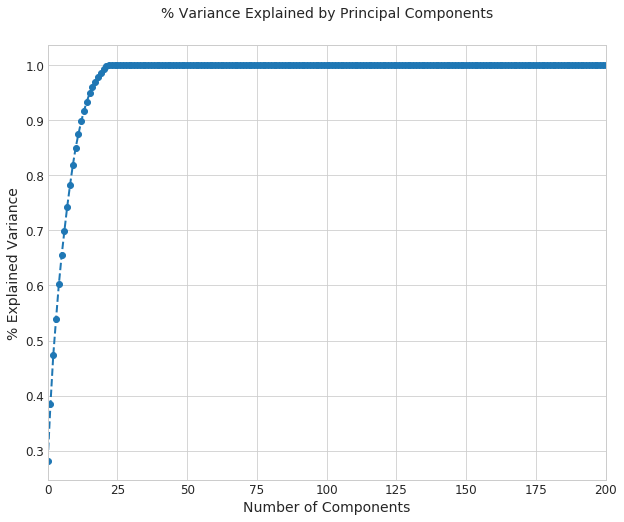

In [89]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [92]:
pca=PCA(n_components=25,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 25 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 25 components is: 0.999952639068


In [93]:
print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_21,y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [94]:
## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [96]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,25).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.905163013848
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31728   151    31879
True        3328  1477     4805
__all__    35056  1628    36684

Accuracy of the KNN model for twst data is: 0.903183602268
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7918    38     7956
True         850   366     1216
__all__     8768   404     9172



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.883982117544
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29112  2767    31879
True        1489  3316     4805
__all__    30601  6083    36684

Accuracy of the Logistic Regression model for twst data is: 0.882359354557
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7270   686     7956
True         393   823     1216
__all__     7663  1509     9172



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.920046886926
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29398  2481    31879
True         452  4353     4805
__all__    29850  6834    36684

Accuracy of the Random Forest Classifier for twst data is: 0.908089838639
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7299   657     7956
True         186  1030     1216
__all__     7485  1687     9172



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.904699596554
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29255  2624    31879
True         872  3933     4805
__all__    30127  6557    36684

Accuracy of the Ada Boost Classifier for twst data is: 0.901875272569
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7294   662     7956
True         238   978     1216
__all__     7532  1640     9172



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.910097045033
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29356  2523    31879
True         775  4030     4805
__all__    30131  6553    36684

Accuracy of the Gradient Boosting Classifier for twst data is: 0.905473179241
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7313   643     7956
True         224   992     1216
__all__     7537  1635     9172



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.921627957693
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29414  2465    31879
True         410  4395     4805
__all__    29824  6860    36684

Accuracy of the Extra Tree Classifier for twst data is: 0.906672481465
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7287   669     7956
True         187  1029     1216
__all__     7474  1698     9172



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.919965107404
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29405  2474    31879
True         462  4343     4805
__all__    29867  6817    36684

Accuracy of the Bagging model for twst data is: 0.907762756215
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7294   662     7956
True         184  1032     1216
__all__     7478  1694     9172



Neural Network-1
The accuracy of the model on training data is: 0.907670919202


Predicted  False  True  __all__
Actual                         
False      29130  2749    31879
True         638  4167     4805
__all__    29768  6916    36684

The accuracy of the model on test data is: 0.904273877017


Predicted  False  True  __all__
Actual                         
False       7275   681     7956
True         197  1019     1216
__all__     7472  1700     9172

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [97]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [98]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.905163,1477.0,31728.0,151.0,3328.0,0.004737,0.692612
LogisticRegression,0.883982,3316.0,29112.0,2767.0,1489.0,0.086797,0.309886
RandomForestClassifier,0.920047,4353.0,29398.0,2481.0,452.0,0.077826,0.094069
AdaBoostClassifier,0.904700,3933.0,29255.0,2624.0,872.0,0.082311,0.181478
GradientBoostingClassifier,0.910097,4030.0,29356.0,2523.0,775.0,0.079143,0.161290
ExtraTreeClassifier,0.921628,4395.0,29414.0,2465.0,410.0,0.077324,0.085328
BaggingClassifier,0.919965,4343.0,29405.0,2474.0,462.0,0.077606,0.096150
Neural Network-1,0.907671,4167.0,29130.0,2749.0,638.0,0.086232,0.132778


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.903184,366.0,7918.0,38.0,850.0,0.004776,0.699013,0.648105
LogisticRegression,0.882359,823.0,7270.0,686.0,393.0,0.086224,0.323191,0.795292
RandomForestClassifier,0.908090,1030.0,7299.0,657.0,186.0,0.082579,0.152961,0.882230
AdaBoostClassifier,0.901875,978.0,7294.0,662.0,238.0,0.083208,0.195724,0.860534
GradientBoostingClassifier,0.905473,992.0,7313.0,643.0,224.0,0.080820,0.184211,0.867485
ExtraTreeClassifier,0.906672,1029.0,7287.0,669.0,187.0,0.084087,0.153783,0.881065
BaggingClassifier,0.907763,1032.0,7294.0,662.0,184.0,0.083208,0.151316,0.882738
Neural Network-1,0.904274,1019.0,7275.0,681.0,197.0,0.085596,0.162007,0.882738


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [100]:
feat_impt_plot(np.average(feat_imp,axis=0),np.arange(0,25).astype(str))

### <a id='4' style="text-decoration : none; color : #000000;"> 5. Over Sampling</a>

In [112]:
columns=col_values[col_values['95_%_same_values']==False].index.values
print('Features we will be using:\n')
columns=list(columns)
columns.remove('Target')
display(columns)

Features we will be using:



['http_header_cache-control_set_max-age',
 'http_header_cache-control_set_must-revalidate',
 'http_header_cache-control_set_no-cache',
 'http_header_cache-control_set_no-store',
 'http_header_cache-control_set_private',
 'http_header_cache-control_set_public',
 'http_header_connection_close',
 'http_header_connection_keep-alive',
 'http_header_content-encoding_gzip',
 'http_header_content-language_text/html',
 'http_header_content-length',
 'http_header_expect-ctmax-age',
 'http_header_expect-ctreport-uri',
 'http_header_marco_contenttext',
 'http_header_pragmano-cache',
 'http_header_server_apache',
 'http_header_server_nginx',
 'http_header_strict-transport-security_max-age',
 'http_header_transfer-encoding_chunked',
 'http_header_vary_accept',
 'http_header_vary_accept-encoding',
 'http_header_vary_age',
 'http_header_vary_user-agent',
 'http_header_via_1.1',
 'http_header_x-cintent-type-options_nosniff',
 'http_header_x-xss-enabled']

In [113]:
### Preparing our training and test sets
X=df[columns].values
y=df.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(X_train, Y_train)

The train/test split ratio is 80:20


/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning:

Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.



In [114]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [115]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.910853807776
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      28942   2927    31869
True        2755  29114    31869
__all__    31697  32041    63738

Accuracy of the KNN model for twst data is: 0.895660706498
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7151   815     7966
True         142  1064     1206
__all__     7293  1879     9172



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.866735699269
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26499   5370    31869
True        3124  28745    31869
__all__    29623  34115    63738

Accuracy of the Logistic Regression model for twst data is: 0.839838639337
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6606  1360     7966
True         109  1097     1206
__all__     6715  2457     9172



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.932599077473
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      28544   3325    31869
True         971  30898    31869
__all__    29515  34223    63738

Accuracy of the Random Forest Classifier for twst data is: 0.883994766681
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7007   959     7966
True         105  1101     1206
__all__     7112  2060     9172



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.86722206533
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26839   5030    31869
True        3433  28436    31869
__all__    30272  33466    63738

Accuracy of the Ada Boost Classifier for twst data is: 0.84943305713
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6718  1248     7966
True         133  1073     1206
__all__     6851  2321     9172



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.891885531394
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      27859   4010    31869
True        2881  28988    31869
__all__    30740  32998    63738

Accuracy of the Gradient Boosting Classifier for twst data is: 0.87887047536
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6963  1003     7966
True         108  1098     1206
__all__     7071  2101     9172



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.934842637045
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      28581   3288    31869
True         865  31004    31869
__all__    29446  34292    63738

Accuracy of the Extra Tree Classifier for twst data is: 0.882359354557
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6994   972     7966
True         107  1099     1206
__all__     7101  2071     9172



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.932520631335
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      28574   3295    31869
True        1006  30863    31869
__all__    29580  34158    63738

Accuracy of the Bagging model for twst data is: 0.88508504143
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7011   955     7966
True          99  1107     1206
__all__     7110  2062     9172



Neural Network-1
The accuracy of the model on training data is: 0.910477266309


Predicted  False   True  __all__
Actual                          
False      28002   3867    31869
True        1839  30030    31869
__all__    29841  33897    63738

The accuracy of the model on test data is: 0.882904491932


Predicted  False  True  __all__
Actual                         
False       6994   972     7966
True         102  1104     1206
__all__     7096  2076     9172

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [116]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [117]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.910854,29114.0,28942.0,2927.0,2755.0,0.091845,0.086448
LogisticRegression,0.866736,28745.0,26499.0,5370.0,3124.0,0.168502,0.098026
RandomForestClassifier,0.932599,30898.0,28544.0,3325.0,971.0,0.104333,0.030468
AdaBoostClassifier,0.867222,28436.0,26839.0,5030.0,3433.0,0.157834,0.107722
GradientBoostingClassifier,0.891886,28988.0,27859.0,4010.0,2881.0,0.125828,0.090401
ExtraTreeClassifier,0.934843,31004.0,28581.0,3288.0,865.0,0.103172,0.027142
BaggingClassifier,0.932521,30863.0,28574.0,3295.0,1006.0,0.103392,0.031567
Neural Network-1,0.910477,30030.0,28002.0,3867.0,1839.0,0.121340,0.057705


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.895661,1064.0,7151.0,815.0,142.0,0.102310,0.117745,0.889973
LogisticRegression,0.839839,1097.0,6606.0,1360.0,109.0,0.170726,0.090381,0.869446
RandomForestClassifier,0.883995,1101.0,7007.0,959.0,105.0,0.120387,0.087065,0.896274
AdaBoostClassifier,0.849433,1073.0,6718.0,1248.0,133.0,0.156666,0.110282,0.866526
GradientBoostingClassifier,0.878870,1098.0,6963.0,1003.0,108.0,0.125910,0.089552,0.892269
ExtraTreeClassifier,0.882359,1099.0,6994.0,972.0,107.0,0.122019,0.088723,0.894629
BaggingClassifier,0.885085,1107.0,7011.0,955.0,99.0,0.119885,0.082090,0.899013
Neural Network-1,0.882904,1104.0,6994.0,972.0,102.0,0.122019,0.084577,0.899013


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [118]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='5' style="text-decoration : none; color : #000000;"> 6. Under Sampling</a>

In [119]:
df_non=df[df.Target==0]
df_mal=df[df.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X=df_u[columns]
y=df_u.Target.values

feature_name = X.columns.tolist()
print("Shape after undersampling",df_u.shape)
df_u.head()

Shape after undersampling (12042, 274)


,index,Target,http_header-access-control-origin_http:,http_header-access-control-origin_https:,http_header_access-control-allow-credentials,http_header_access-control-allow-methods_cancelupload,http_header_access-control-allow-methods_checkin,http_header_access-control-allow-methods_connect,http_header_access-control-allow-methods_debug,http_header_access-control-allow-methods_delete,http_header_access-control-allow-methods_get,http_header_access-control-allow-methods_head,http_header_access-control-allow-methods_link,http_header_access-control-allow-methods_mkcol,http_header_access-control-allow-methods_move,http_header_access-control-allow-methods_options,http_header_access-control-allow-methods_patch,http_header_access-control-allow-methods_post,http_header_access-control-allow-methods_propfind,http_header_access-control-allow-methods_put,http_header_access-control-allow-methods_report,http_header_access-control-allow-methods_should,http_header_access-control-allow-methods_trace,http_header_access-control-allow-methods_unlink,http_header_access-control-allow-methods_update,http_header_access-control-custom_count,http_header_access-control-expose-total_count,http_header_access-control-max-age,http_header_cache-control_set_max-age,http_header_cache-control_set_must-revalidate,http_header_cache-control_set_no-cache,http_header_cache-control_set_no-store,http_header_cache-control_set_no-transform,http_header_cache-control_set_private,http_header_cache-control_set_proxy-revalidate,http_header_cache-control_set_public,http_header_cache-control_set_s-maxage,http_header_connection_close,http_header_connection_keep-alive,http_header_content-disposition_attachment,http_header_content-disposition_inline,http_header_content-encoding_deflate,http_header_content-encoding_gzip,http_header_content-language_ae,http_header_content-language_af,http_header_content-language_am,http_header_content-language_an,http_header_content-language_application/json,http_header_content-language_application/octet-stream,http_header_content-language_ar,http_header_content-language_az,http_header_content-language_be,http_header_content-language_bi,http_header_content-language_br,http_header_content-language_bs,http_header_content-language_ca,http_header_content-language_ch,http_header_content-language_co,http_header_content-language_cs,http_header_content-language_cu,http_header_content-language_cy,http_header_content-language_da,http_header_content-language_de,http_header_content-language_disposition,http_header_content-language_el,http_header_content-language_en,http_header_content-language_es,http_header_content-language_et,http_header_content-language_fa,http_header_content-language_fi,http_header_content-language_fr,http_header_content-language_ga,http_header_content-language_gl,http_header_content-language_ha,http_header_content-language_he,http_header_content-language_hr,http_header_content-language_hu,http_header_content-language_hy,http_header_content-language_id,http_header_content-language_ie,http_header_content-language_ig,http_header_content-language_image/jpeg,http_header_content-language_image/png,http_header_content-language_it,http_header_content-language_ja,http_header_content-language_kk,http_header_content-language_ko,http_header_content-language_kr,http_header_content-language_lt,http_header_content-language_lv,http_header_content-language_mk,http_header_content-language_ml,http_header_content-language_mr,http_header_content-language_ms,http_header_content-language_my,http_header_content-language_nb,http_header_content-language_nd,http_header_content-language_ne,http_header_content-language_ng,http_header_content-language_nl,http_header_content-language_no,http_header_content-language_pl,http_header_content-language_pt,http_header_content-language_ro,http_header_content-language_ru,http_header_content-language_sa,http_header_content-language_se,http_header_content-language_sg,http_header_content-language_si,http_header_content-language_sk,

In [120]:
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)


The train/test split ratio is 80:20


In [121]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [123]:
print('Features we will be using:\n')
display(columns)

Features we will be using:



['http_header_cache-control_set_max-age',
 'http_header_cache-control_set_must-revalidate',
 'http_header_cache-control_set_no-cache',
 'http_header_cache-control_set_no-store',
 'http_header_cache-control_set_private',
 'http_header_cache-control_set_public',
 'http_header_connection_close',
 'http_header_connection_keep-alive',
 'http_header_content-encoding_gzip',
 'http_header_content-language_text/html',
 'http_header_content-length',
 'http_header_expect-ctmax-age',
 'http_header_expect-ctreport-uri',
 'http_header_marco_contenttext',
 'http_header_pragmano-cache',
 'http_header_server_apache',
 'http_header_server_nginx',
 'http_header_strict-transport-security_max-age',
 'http_header_transfer-encoding_chunked',
 'http_header_vary_accept',
 'http_header_vary_accept-encoding',
 'http_header_vary_age',
 'http_header_vary_user-agent',
 'http_header_via_1.1',
 'http_header_x-cintent-type-options_nosniff',
 'http_header_x-xss-enabled']

In [124]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.89857780546
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4277   561     4838
True         416  4379     4795
__all__     4693  4940     9633

Accuracy of the KNN model for twst data is: 0.889165628892
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1035   148     1183
True         119  1107     1226
__all__     1154  1255     2409



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.860271981729
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4011   827     4838
True         519  4276     4795
__all__     4530  5103     9633

Accuracy of the Logistic Regression model for twst data is: 0.871731008717
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        991   192     1183
True         117  1109     1226
__all__     1108  1301     2409



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.925153119485
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4303   535     4838
True         186  4609     4795
__all__     4489  5144     9633

Accuracy of the Random Forest Classifier for twst data is: 0.892071398921
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1021   162     1183
True          98  1128     1226
__all__     1119  1290     2409



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.866604380774
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4053   785     4838
True         500  4295     4795
__all__     4553  5080     9633

Accuracy of the Ada Boost Classifier for twst data is: 0.873806558738
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1005   178     1183
True         126  1100     1226
__all__     1131  1278     2409



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.887158725215
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4261   577     4838
True         510  4285     4795
__all__     4771  4862     9633

Accuracy of the Gradient Boosting Classifier for twst data is: 0.884599418846
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1035   148     1183
True         130  1096     1226
__all__     1165  1244     2409



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.929305512301
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4332   506     4838
True         175  4620     4795
__all__     4507  5126     9633

Accuracy of the Extra Tree Classifier for twst data is: 0.892486508925
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1023   160     1183
True          99  1127     1226
__all__     1122  1287     2409



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.925879788228
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4314   524     4838
True         190  4605     4795
__all__     4504  5129     9633

Accuracy of the Bagging model for twst data is: 0.899543378995
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1033   150     1183
True          92  1134     1226
__all__     1125  1284     2409



Neural Network-1
The accuracy of the model on training data is: 0.904287345583


Predicted  False  True  __all__
Actual                         
False       4271   567     4838
True         355  4440     4795
__all__     4626  5007     9633

The accuracy of the model on test data is: 0.895807388958


Predicted  False  True  __all__
Actual                         
False       1040   143     1183
True         108  1118     1226
__all__     1148  1261     2409

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [125]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [126]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.898578,4379.0,4277.0,561.0,416.0,0.115957,0.086757
LogisticRegression,0.860272,4276.0,4011.0,827.0,519.0,0.170938,0.108238
RandomForestClassifier,0.925153,4609.0,4303.0,535.0,186.0,0.110583,0.038790
AdaBoostClassifier,0.866604,4295.0,4053.0,785.0,500.0,0.162257,0.104275
GradientBoostingClassifier,0.887159,4285.0,4261.0,577.0,510.0,0.119264,0.106361
ExtraTreeClassifier,0.929306,4620.0,4332.0,506.0,175.0,0.104589,0.036496
BaggingClassifier,0.925880,4605.0,4314.0,524.0,190.0,0.108309,0.039625
Neural Network-1,0.904287,4440.0,4271.0,567.0,355.0,0.117197,0.074035


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.889166,1107.0,1035.0,148.0,119.0,0.125106,0.097064,0.888915
LogisticRegression,0.871731,1109.0,991.0,192.0,117.0,0.162299,0.095432,0.871134
RandomForestClassifier,0.892071,1128.0,1021.0,162.0,98.0,0.136940,0.079935,0.891563
AdaBoostClassifier,0.873807,1100.0,1005.0,178.0,126.0,0.150465,0.102773,0.873381
GradientBoostingClassifier,0.884599,1096.0,1035.0,148.0,130.0,0.125106,0.106036,0.884429
ExtraTreeClassifier,0.892487,1127.0,1023.0,160.0,99.0,0.135249,0.080750,0.892000
BaggingClassifier,0.899543,1134.0,1033.0,150.0,92.0,0.126796,0.075041,0.899081
Neural Network-1,0.895807,1118.0,1040.0,143.0,108.0,0.120879,0.088091,0.899081


### <a id='5.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [127]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

In [128]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')